
feature-level fusion with concatanation



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import timm
import os
import random
from pathlib import Path
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/dataset/AMDNet23_Datasetzip.zip" -d "/content/AMDNet23"


Mounted at /content/drive


In [4]:
# Configuration
class CFG:
    #DATA PATHS
    DATA_ROOT = "/content/AMDNet23/AMDNet23_Dataset"

    #HYPERPARAMETERS
    IMG_SIZE = 224
    BATCH_SIZE = 16
    SEED = 42
    NUM_WORKERS = 2


    #TRAINING
    EPOCHS_HEAD = 5   # Phase 1: Warming up the fusion layer
    EPOCHS_FULL = 15  # Phase 2: Training the whole system
    LR_HEAD = 1e-3
    LR_FULL = 5e-5    # Lower LR for fine-tuning backbones
    WD = 1e-2
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    MODELS = [
        "tf_efficientnetv2_s",
        "densenet121",
        "swin_tiny_patch4_window7_224"
    ]


In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed(CFG.SEED)

In [6]:
# Data Augmentation
train_tfms = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

valid_tfms = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [7]:
train_dir = os.path.join(CFG.DATA_ROOT, "train")
valid_dir = os.path.join(CFG.DATA_ROOT, "valid")

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
valid_ds = datasets.ImageFolder(valid_dir, transform=valid_tfms)

train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,
                          num_workers=CFG.NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=CFG.BATCH_SIZE, shuffle=False,
                          num_workers=CFG.NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['amd', 'cataract', 'diabetes', 'normal']


In [12]:
class FeatureFusionNetwork(nn.Module):
    def __init__(self, model_names, num_classes, embed_dim=512):
        super().__init__()
        self.backbones = nn.ModuleList()
        self.projections = nn.ModuleList()

        for name in model_names:
            print(f"Loading backbone: {name}")
            # Extract features
            m = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
            self.backbones.append(m)
            self.projections.append(nn.Linear(m.num_features, embed_dim))

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, batch_first=True)

        self.fusion_layer = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        encoded_feats = [proj(m(x)) for m, proj in zip(self.backbones, self.projections)]
        combined_seq = torch.stack(encoded_feats, dim=1)

        attn_output, _ = self.multihead_attn(combined_seq, combined_seq, combined_seq)

        fused_out = attn_output.mean(dim=1)

        return self.fusion_layer(fused_out)

In [13]:
def set_backbone_trainable(model, status: bool):
    for m in model.backbones:
        for p in m.parameters():
            p.requires_grad = status

In [14]:
def run_epoch(model, loader, optimizer, scaler, criterion, is_train=True):
    model.train() if is_train else model.eval()
    total_loss, all_preds, all_labels = 0, [], []

    use_cuda = CFG.DEVICE == "cuda"

    with torch.set_grad_enabled(is_train):
        for x, y in loader:
            x, y = x.to(CFG.DEVICE), y.to(CFG.DEVICE)


            with autocast(enabled=use_cuda):
                logits = model(x)
                loss = criterion(logits, y)

            if is_train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item() * x.size(0)
            all_preds.append(logits.argmax(1).cpu().numpy())
            all_labels.append(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    y_true, y_pred = np.concatenate(all_labels), np.concatenate(all_preds)
    return avg_loss, accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

In [16]:
#  Training Function

def train_feature_fusion():
    model = FeatureFusionNetwork(CFG.MODELS, num_classes).to(CFG.DEVICE)
    scaler = GradScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Early Stopping Config
    patience = 5
    counter = 0
    best_acc = 0

    # History for plotting
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    #Branches frozen
    print("\nTraining Fusion Head")
    set_backbone_trainable(model, False)
    optimizer = optim.AdamW(model.fusion_layer.parameters(), lr=CFG.LR_HEAD)

    for epoch in range(1, CFG.EPOCHS_HEAD + 1):
        tr_loss, tr_acc, _ = run_epoch(model, train_loader, optimizer, scaler, criterion)
        val_loss, val_acc, val_f1 = run_epoch(model, valid_loader, None, scaler, criterion, is_train=False)

        history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(tr_acc); history['val_acc'].append(val_acc)

        print(f"Ep {epoch}/{CFG.EPOCHS_HEAD} | TrLoss: {tr_loss:.3f} | ValLoss: {val_loss:.3f} | TrAcc: {tr_acc:.4f} | ValAcc: {val_acc:.4f}")


    # fine-tuning, feature unfrozen

    print("\n Unfreeze all layers")
    set_backbone_trainable(model, True)
    optimizer = optim.AdamW(model.parameters(), lr=CFG.LR_FULL, weight_decay=CFG.WD)

    for epoch in range(1, CFG.EPOCHS_FULL + 1):
        tr_loss, tr_acc, _ = run_epoch(model, train_loader, optimizer, scaler, criterion)
        val_loss, val_acc, val_f1 = run_epoch(model, valid_loader, None, scaler, criterion, is_train=False)

        history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(tr_acc); history['val_acc'].append(val_acc)

        print(f"Ep {epoch}/{CFG.EPOCHS_FULL} | TrLoss: {tr_loss:.3f} | ValLoss: {val_loss:.3f} | TrAcc: {tr_acc:.4f} | ValAcc: {val_acc:.4f}")

        # Early Stopping
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_fusion_model.pth")
            counter = 0 # Reset counter
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    return history

history = train_feature_fusion()


Loading backbone: tf_efficientnetv2_s
Loading backbone: densenet121
Loading backbone: swin_tiny_patch4_window7_224

Training Fusion Head


/tmp/ipython-input-3394638873.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 1/5 | TrLoss: 0.843 | ValLoss: 0.689 | TrAcc: 0.7258 | ValAcc: 0.8250


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 2/5 | TrLoss: 0.734 | ValLoss: 0.694 | TrAcc: 0.7949 | ValAcc: 0.8125


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 3/5 | TrLoss: 0.742 | ValLoss: 0.692 | TrAcc: 0.7930 | ValAcc: 0.8200


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 4/5 | TrLoss: 0.698 | ValLoss: 0.654 | TrAcc: 0.8294 | ValAcc: 0.8250


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 5/5 | TrLoss: 0.681 | ValLoss: 0.643 | TrAcc: 0.8306 | ValAcc: 0.8475

 Unfreeze all layers


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 1/15 | TrLoss: 0.655 | ValLoss: 0.460 | TrAcc: 0.8538 | ValAcc: 0.9675


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 2/15 | TrLoss: 0.517 | ValLoss: 0.503 | TrAcc: 0.9379 | ValAcc: 0.9375


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 3/15 | TrLoss: 0.491 | ValLoss: 0.451 | TrAcc: 0.9479 | ValAcc: 0.9600


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 4/15 | TrLoss: 0.458 | ValLoss: 0.431 | TrAcc: 0.9668 | ValAcc: 0.9700


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 5/15 | TrLoss: 0.447 | ValLoss: 0.424 | TrAcc: 0.9711 | ValAcc: 0.9750


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 6/15 | TrLoss: 0.426 | ValLoss: 0.430 | TrAcc: 0.9818 | ValAcc: 0.9675


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 7/15 | TrLoss: 0.430 | ValLoss: 0.404 | TrAcc: 0.9768 | ValAcc: 0.9800


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 8/15 | TrLoss: 0.413 | ValLoss: 0.401 | TrAcc: 0.9881 | ValAcc: 0.9850


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 9/15 | TrLoss: 0.409 | ValLoss: 0.432 | TrAcc: 0.9875 | ValAcc: 0.9575


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 10/15 | TrLoss: 0.401 | ValLoss: 0.433 | TrAcc: 0.9937 | ValAcc: 0.9650


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 11/15 | TrLoss: 0.399 | ValLoss: 0.423 | TrAcc: 0.9937 | ValAcc: 0.9675


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 12/15 | TrLoss: 0.395 | ValLoss: 0.405 | TrAcc: 0.9944 | ValAcc: 0.9750


/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):
/tmp/ipython-input-677519207.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


Ep 13/15 | TrLoss: 0.396 | ValLoss: 0.438 | TrAcc: 0.9918 | ValAcc: 0.9625
Early stopping triggered after 13 epochs.


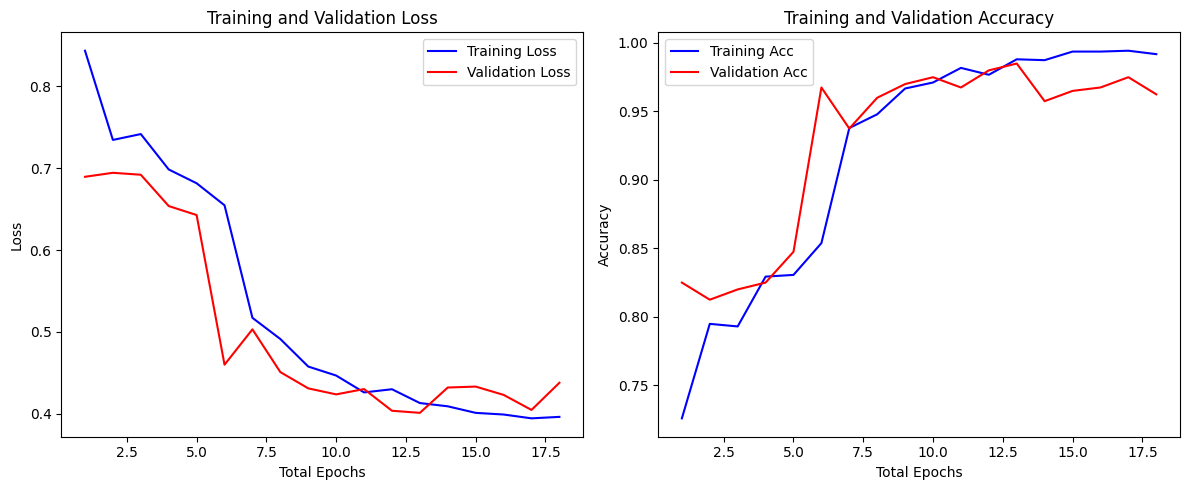

In [17]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Total Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Total Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


--- FINAL EVALUATION ---
Loading backbone: tf_efficientnetv2_s
Loading backbone: densenet121
Loading backbone: swin_tiny_patch4_window7_224
              precision    recall  f1-score   support

         amd       1.00      1.00      1.00       100
    cataract       1.00      1.00      1.00       100
    diabetes       0.99      0.95      0.97       100
      normal       0.95      0.99      0.97       100

    accuracy                           0.98       400
   macro avg       0.99      0.99      0.98       400
weighted avg       0.99      0.98      0.98       400



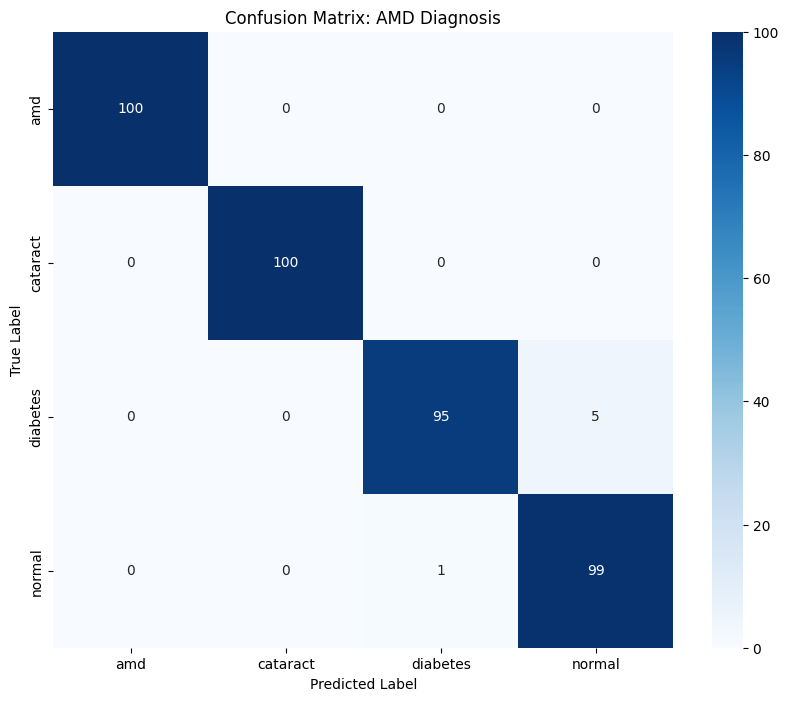

In [18]:
# 8. Evaluation Function
def test_model(model_path):
    print("\n--- FINAL EVALUATION ---")

    model = FeatureFusionNetwork(CFG.MODELS, num_classes).to(CFG.DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(CFG.DEVICE)
            logits = model(x)
            all_preds.append(logits.argmax(1).cpu().numpy())
            all_labels.append(y.numpy())
    y_true, y_pred = np.concatenate(all_labels), np.concatenate(all_preds)

    print(classification_report(y_true, y_pred, target_names=class_names))


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: AMD Diagnosis')
    plt.show()

test_model("best_fusion_model.pth")